In [51]:
from emrecharge.datasets import EMDataset
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
SPATIAL_UNIT = 'm'
em_data = EMDataset(
    "./em_resistivity.csv", 
    "./thickness.csv",
    SPATIAL_UNIT
)

In [52]:
gdf = gpd.read_file("subbasins_cv_rockphysics.geojson")

In [53]:
gdf_cv = gpd.read_file("../data/shp/cv.shp")
gdf_cv_3310 = gdf_cv.to_crs(3310)

In [54]:
geom = gdf_cv_3310.geometry[0]

In [55]:
x, y = geom.exterior.xy
x = np.array(x)
y = np.array(y)

## Step 1: Rotate the system

In [56]:
x0_max = 128989.96617666919
y0_min = -344621.31282856315

In [57]:
from SimPEG.utils import rotate_points_from_normals
x_norm = x-x0_max
y_norm = y-y0_min
xy_norm = np.c_[x_norm, y_norm, np.zeros_like(y_norm)]

In [58]:
xy_norm_rot = rotate_points_from_normals(xy_norm, np.array([-352306.81278939766, 643151.2476351159,0]), np.array([0,1,0]))

In [59]:
def rotate_vector(xy, invert=False):
    if invert:
        xy_norm = np.c_[xy[:,0], xy[:,1], np.zeros_like(xy[:,0])]
        xy_norm_rot = rotate_points_from_normals(xy_norm, np.array([0,1,0]), np.array([-352306.81278939766, 643151.2476351159,0]))
        xy_norm_rot[:,0] += x0_max
        xy_norm_rot[:,1] += y0_min
    else:
        xy_norm = np.c_[xy[:,0]-x0_max, xy[:,1]-y0_min, np.zeros_like(xy[:,0])]
        xy_norm_rot = rotate_points_from_normals(xy_norm, np.array([-352306.81278939766, 643151.2476351159,0]), np.array([0,1,0]))
    return xy_norm_rot[:,:2]

In [60]:
xy_norm_rot = rotate_vector(np.c_[x, y])

In [61]:
# fig = plt.figure()
# plt.plot(x_norm, y_norm, ',')
# plt.plot(xy_norm_rot[:,0], xy_norm_rot[:,1], ',')
# ax = plt.gca()
# ax.set_aspect(1)

## Step 2: Create 400m x 400 m grid

In [62]:
from discretize import TensorMesh
from discretize.utils import mesh_builder_xyz
import pandas as pd

In [63]:
mesh = mesh_builder_xyz(xy_norm_rot[:,:2], [400, 400], padding_distance=[[1000, 1000], [1000, 1000]], expansion_factor=1)
mesh_coarse = mesh_builder_xyz(xy_norm_rot[:,:2], [1600, 1600], padding_distance=[[1000, 1000], [1000, 1000]], expansion_factor=1)

In [64]:
df_coloc_sed = pd.read_csv("colocated_sed_locations_600m.csv")
xy_sed_coloc_600m = df_coloc_sed[['UTMX', 'UTMY']].values

In [65]:
import pandas as pd
df_wt = pd.read_csv("wt_cv.csv")
xy_wt = df_wt[['UTMX', 'UTMY']].values
xy_wt_rot = rotate_vector(xy_wt)

In [66]:
geoms = gpd.points_from_xy(em_data.xy[:,0], em_data.xy[:,1])
gdf_aem_pts = gpd.GeoDataFrame(data={}, geometry=geoms)
gdf_aem_pts = gdf_aem_pts.set_crs(epsg=3310)
gdf_aem_pts.to_file('./points/aem_cv_pts.shp')

In [67]:
geoms = gpd.points_from_xy(xy_sed_coloc_600m[:,0], xy_sed_coloc_600m[:,1])
gdf_sed_pts = gpd.GeoDataFrame(data={}, geometry=geoms)
gdf_sed_pts = gdf_sed_pts.set_crs(epsg=3310)
gdf_sed_pts.to_file('./points/sedcv_pts.shp')

In [68]:
geoms = gpd.points_from_xy(xy_wt[:,0], xy_wt[:,1])
gdf_wt__pts = gpd.GeoDataFrame(data={}, geometry=geoms)
gdf_wt__pts = gdf_wt__pts.set_crs(epsg=3310)
gdf_wt__pts.to_file('./points/wt_cv_pts.shp')

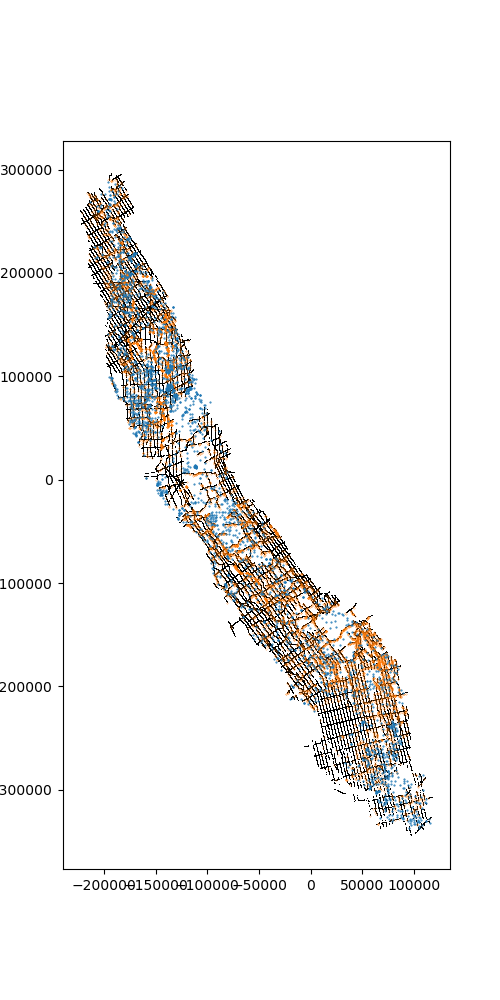

In [69]:
fig, ax = plt.subplots(1,1, figsize=(5, 10))
# mesh.plot_grid(ax=ax)
plt.plot(em_data.xy[:,0],em_data.xy[:,1], 'k,')
plt.plot(xy_sed_coloc_600m[:,0],xy_sed_coloc_600m[:,1], '.', ms=0.4, color='C1')
plt.plot(xy_wt[:,0],xy_wt[:,1], '.', ms=1, color='C0')
ax.set_aspect(1)

In [70]:
em_data.num_soundings

376761

## Step 3: Interpolate water table

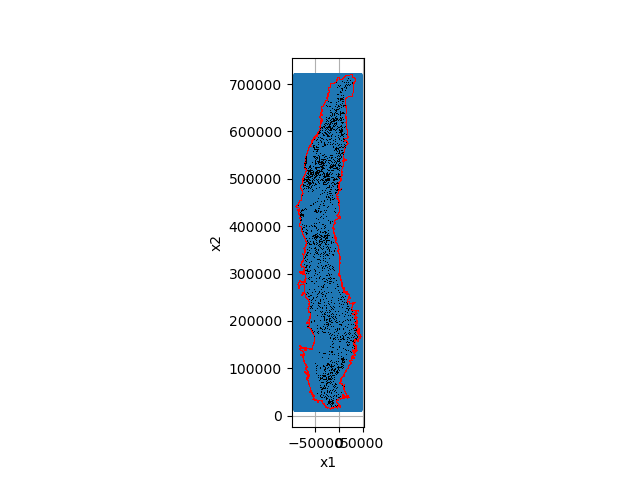

In [71]:
fig, ax = plt.subplots(1,1)
mesh.plot_grid(ax=ax)
plt.plot(xy_norm_rot[:,0], xy_norm_rot[:,1], 'r,')
plt.plot(xy_wt_rot[:,0], xy_wt_rot[:,1], 'k,')
ax.set_aspect(1)

In [72]:
from emrecharge.utils import inverse_distance_interpolation

In [73]:
from verde import distance_mask

In [74]:
from scipy.spatial import cKDTree as kdtree
import numpy.ma as ma

In [75]:
xy_grid = mesh.cell_centers
xy_grid_coarse = mesh_coarse.cell_centers

In [76]:
epsilon = None
power=1
dx, dy = 1000, 1000
gse_wse = df_wt['GSE_WSE'].values.copy()
gse_wse_clip = np.clip(gse_wse, np.percentile(gse_wse, 5), np.percentile(gse_wse, 95))
tree = kdtree(xy_wt_rot[:,:])
k_nearest_points = 100
max_distance = 40000
values = gse_wse_clip[:]
d, inds_idw = tree.query(xy_grid, k=int(k_nearest_points))
if epsilon is None:
    epsilon = np.min([dx, dy])
w = 1.0 / ((d + epsilon) ** power)
wt_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
mask_inds = ~distance_mask(
    (xy_wt_rot[:, 0], xy_wt_rot[:, 1]),
    maxdist=max_distance,
    coordinates=(xy_grid[:,0], xy_grid[:,1]),
)
#     wt_idw[mask_inds] = np.nan
wt_idw = ma.masked_array(wt_idw, mask=mask_inds)

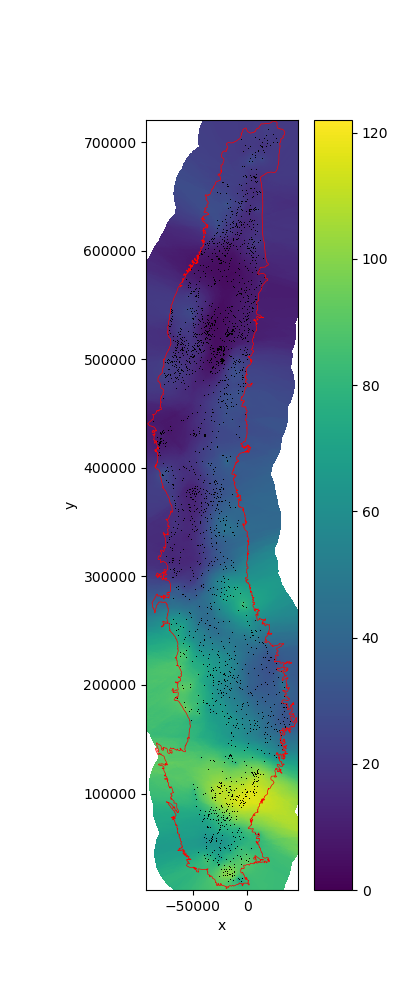

In [77]:
fig, ax = plt.subplots(1,1, figsize=(4, 10))
out = mesh.plot_image(wt_idw, ax=ax, pcolor_opts={"vmin":0, "vmax":122.})
cb = plt.colorbar(out[0])
plt.plot(xy_wt_rot[:,0], xy_wt_rot[:,1], 'k,')
plt.plot(xy_norm_rot[:,0], xy_norm_rot[:,1], 'r-', lw=0.5)
ax.set_aspect(1)

In [78]:
xy_grid_rot = rotate_vector(xy_grid, invert=True)
xy_grid_coarse_rot = rotate_vector(xy_grid_coarse, invert=True)

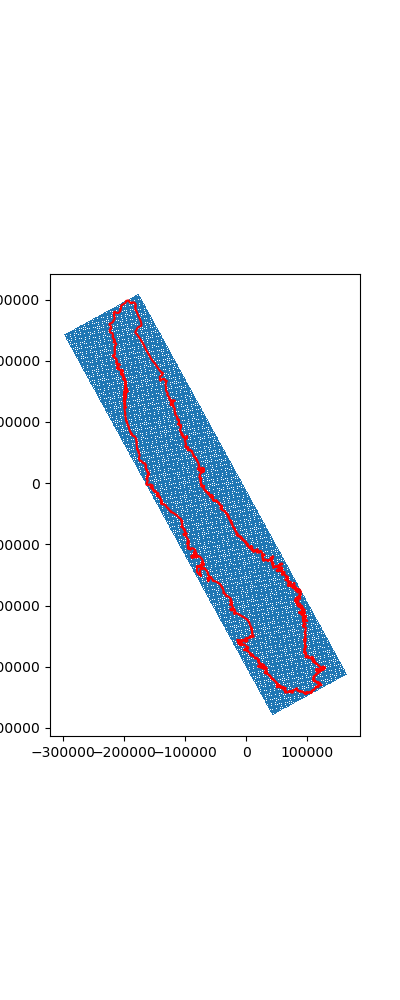

In [79]:
fig, ax = plt.subplots(1,1, figsize=(4, 10))
ax.plot(xy_grid_coarse_rot[:,0], xy_grid_coarse_rot[:,1], ',')
gdf_cv_3310.boundary.plot(ax=ax, color='r')
ax.set_aspect(1)

In [80]:
points_grid = gpd.points_from_xy(xy_grid_rot[:,0], xy_grid_rot[:,1])
gdf_points = gpd.GeoDataFrame(geometry=points_grid, crs=3310)

In [81]:
points_coarse_grid = gpd.points_from_xy(xy_grid_coarse_rot[:,0], xy_grid_coarse_rot[:,1])
gdf_points_coarse = gpd.GeoDataFrame(data={}, geometry=points_coarse_grid, crs=3310)

In [82]:
gdf_subbasin = gdf.set_index('Basin_Su_1', inplace=False)

In [83]:
subbasin_names = list(gdf_subbasin.index)

In [84]:
# inds_cv = gdf_cv_3310.geometry[0].contains(gdf_points_coarse).values.flatten()
# inds_cv_fine = gdf_cv_3310.geometry[0].contains(gdf_points).values.flatten()

In [85]:
gdf_points_coarse_cv = gdf_points_coarse.clip(gdf_cv_3310)
inds_cv = np.zeros(len(gdf_points_coarse), dtype=bool)
inds_cv[list(gdf_points_coarse_cv.index)] = True

In [86]:
gdf_points_cv = gdf_points.clip(gdf_cv_3310)
inds_cv_fine = np.zeros(len(gdf_points), dtype=bool)
inds_cv_fine[list(gdf_points_cv.index)] = True

In [88]:
rho_fine_cv_grid = np.zeros(mesh_coarse.n_cells) * np.nan
rho_coarse_cv_grid = np.zeros(mesh_coarse.n_cells) * np.nan
for name in subbasin_names:
    # if (name == 'SAN JOAQUIN VALLEY - TULARE LAKE') | (name == 'SAN JOAQUIN VALLEY - WESTSIDE'):
    #     pass
    # else:
    tmp = gdf_subbasin.loc[name]
    inds = tmp.geometry.contains(gdf_points_coarse).values.flatten()
    rho_fine_cv_grid[inds] = tmp['rho_fine_50th']
    rho_coarse_cv_grid[inds] = tmp['rho_coarse_50th']
    print (name)

SACRAMENTO VALLEY - BUTTE
SACRAMENTO VALLEY - COLUSA
SACRAMENTO VALLEY - CORNING
SACRAMENTO VALLEY - SOLANO
SACRAMENTO VALLEY - NORTH AMERICAN
SACRAMENTO VALLEY - SUTTER
SACRAMENTO VALLEY - RED BLUFF
SACRAMENTO VALLEY - VINA
SACRAMENTO VALLEY - YOLO
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN
SAN JOAQUIN VALLEY - KAWEAH
SAN JOAQUIN VALLEY - WESTSIDE
SAN JOAQUIN VALLEY - MODESTO
SAN JOAQUIN VALLEY - TULARE LAKE
SAN JOAQUIN VALLEY - KINGS
SAN JOAQUIN VALLEY - CHOWCHILLA
SAN JOAQUIN VALLEY - TURLOCK
SAN JOAQUIN VALLEY - KERN COUNTY
SAN JOAQUIN VALLEY - DELTA-MENDOTA
SAN JOAQUIN VALLEY - MERCED
SAN JOAQUIN VALLEY - MADERA
SAN JOAQUIN VALLEY - TULE


In [89]:
from matplotlib.colors import LogNorm

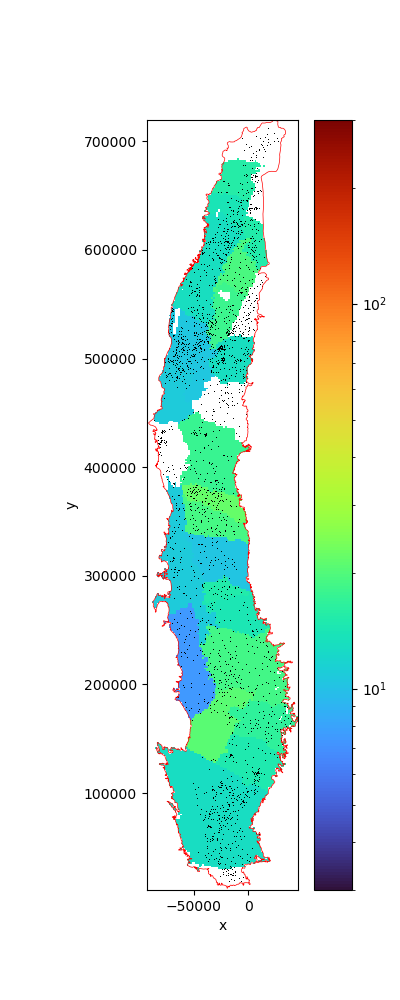

In [90]:
fig, ax = plt.subplots(1,1, figsize=(4, 10))
out = mesh_coarse.plot_image(rho_fine_cv_grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=3, vmax=300), 'cmap':'turbo'})
cb = plt.colorbar(out[0])
plt.plot(xy_wt_rot[:,0], xy_wt_rot[:,1], 'k,')
plt.plot(xy_norm_rot[:,0], xy_norm_rot[:,1], 'r-', lw=0.5)
ax.set_aspect(1)

In [91]:
inds_active = ~np.isnan(rho_fine_cv_grid)
tree = kdtree(xy_grid_coarse[inds_active,:])
k_nearest_points = 50
d, inds_idw = tree.query(xy_grid_coarse[:,:], k=int(k_nearest_points))
if epsilon is None:
    epsilon = np.min([dx, dy])
w = 1.0 / ((d + epsilon) ** power)
values = rho_fine_cv_grid[inds_active]
rho_fine_cv_grid_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
rho_fine_cv_grid_idw = ma.masked_array(rho_fine_cv_grid_idw, mask=~inds_cv)

values = rho_coarse_cv_grid[inds_active]
rho_coarse_cv_grid_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
rho_coarse_cv_grid_idw = ma.masked_array(rho_coarse_cv_grid_idw, mask=~inds_cv)

In [92]:
import dill

In [98]:
results_rock_physics_grid = {
    'rho_fine_cv_grid_idw': rho_fine_cv_grid_idw,
    'rho_coarse_cv_grid_idw': rho_coarse_cv_grid_idw,
    'mesh_coarse': mesh_coarse,
    'xy_grid_coarse_rot': xy_grid_coarse_rot,
    'mesh':mesh,
    'wt_idw':wt_idw,
    'inds_cv_coarse':inds_cv,
    'inds_cv':inds_cv_fine
}

In [99]:
dill.dump(results_rock_physics_grid, open("rock_physics_grid.pik", "wb"))

In [100]:
%matplotlib widget

In [101]:
import matplotlib
matplotlib.rcParams['font.size'] = 10

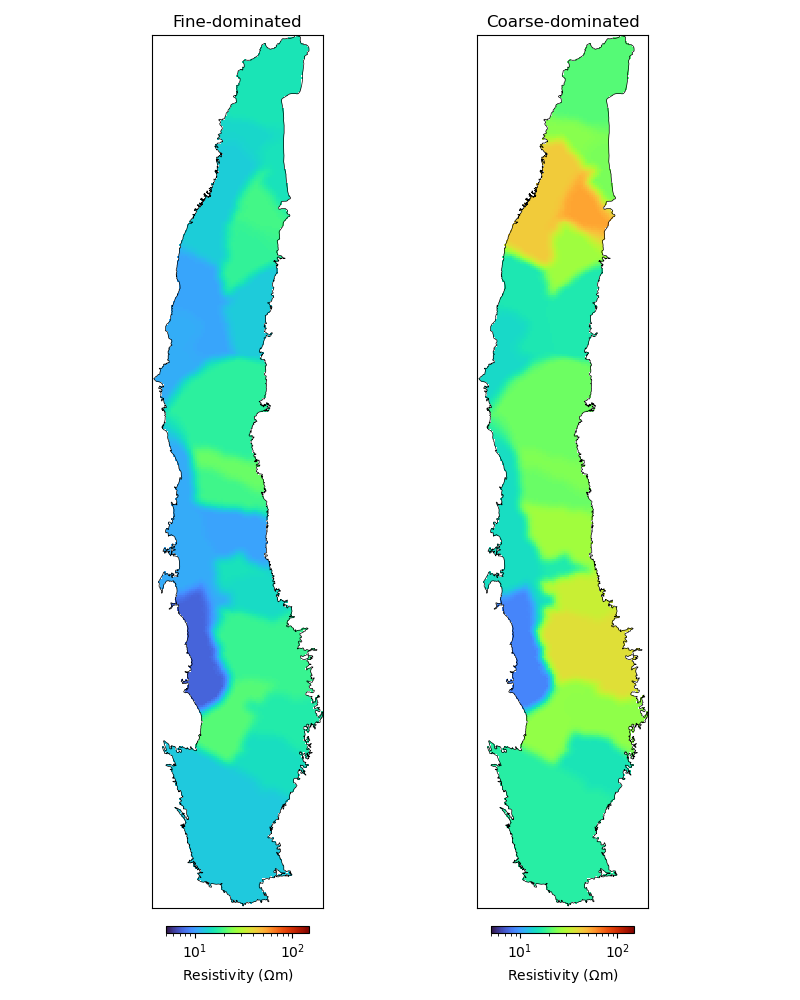

In [102]:
fig, axs = plt.subplots(1,2, figsize=(8, 10))
ax1, ax2 = axs
out = mesh_coarse.plot_image(rho_fine_cv_grid_idw, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=5, vmax=150), 'cmap':'turbo'})
cb1 = plt.colorbar(out[0], ax=ax1, orientation='horizontal', fraction=0.008, pad=0.02)
out = mesh_coarse.plot_image(rho_coarse_cv_grid_idw, ax=ax2, pcolor_opts={'norm':LogNorm(vmin=5, vmax=150), 'cmap':'turbo'})
cb2 = plt.colorbar(out[0], ax=ax2, orientation='horizontal', fraction=0.008, pad=0.02)
cb1.set_label("Resistivity ($\Omega$m)")
cb2.set_label("Resistivity ($\Omega$m)")
for ax in axs:
    ax.plot(xy_norm_rot[:,0], xy_norm_rot[:,1], 'k-', lw=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")    
    ax.set_aspect(1)
ax1.set_title("Fine-dominated")
ax2.set_title("Coarse-dominated")
plt.tight_layout()
plt.show()